In [1]:
import numpy as np

import tensorflow as tf

!pip install -q tensorflow-hub
!pip install -q tfds-nightly
import tensorflow_hub as hub
import tensorflow_datasets as tfds

print("버전: ", tf.__version__)
print("즉시 실행 모드: ", tf.executing_eagerly())
print("허브 버전: ", hub.__version__)
print("GPU", "사용 가능" if tf.config.experimental.list_physical_devices("GPU") else "사용 불가능")

버전:  2.4.1
즉시 실행 모드:  True
허브 버전:  0.12.0
GPU 사용 불가능


In [2]:
# 훈련 세트를 6대 4로 나눕니다.
# 결국 훈련에 15,000개 샘플, 검증에 10,000개 샘플, 테스트에 25,000개 샘플을 사용하게 됩니다.
train_data, validation_data, test_data = tfds.load(
    name="imdb_reviews", 
    split=('train[:60%]', 'train[60%:]', 'test'),
    as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling imdb_reviews-train.tfrecord...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling imdb_reviews-test.tfrecord...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling imdb_reviews-unsupervised.tfrecord...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to C:\Users\Overthinking\tensorflow_datasets\imdb_reviews\plain_text\1.0.0. Subsequent calls will reuse this data.


In [3]:
train_examples_batch, train_labels_batch = next(iter(train_data.batch(10)))
train_examples_batch

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
       b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell 

In [4]:
train_labels_batch

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0], dtype=int64)>

In [5]:
embedding = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)
hub_layer(train_examples_batch[:3])

<tf.Tensor: shape=(3, 20), dtype=float32, numpy=
array([[ 1.765786  , -3.882232  ,  3.9134233 , -1.5557289 , -3.3362343 ,
        -1.7357955 , -1.9954445 ,  1.2989551 ,  5.081598  , -1.1041286 ,
        -2.0503852 , -0.72675157, -0.65675956,  0.24436149, -3.7208383 ,
         2.0954835 ,  2.2969332 , -2.0689783 , -2.9489717 , -1.1315987 ],
       [ 1.8804485 , -2.5852382 ,  3.4066997 ,  1.0982676 , -4.056685  ,
        -4.891284  , -2.785554  ,  1.3874227 ,  3.8476458 , -0.9256538 ,
        -1.896706  ,  1.2113281 ,  0.11474707,  0.76209456, -4.8791065 ,
         2.906149  ,  4.7087674 , -2.3652055 , -3.5015898 , -1.6390051 ],
       [ 0.71152234, -0.6353217 ,  1.7385626 , -1.1168286 , -0.5451594 ,
        -1.1808156 ,  0.09504455,  1.4653089 ,  0.66059524,  0.79308075,
        -2.2268345 ,  0.07446612, -1.4075904 , -0.70645386, -1.907037  ,
         1.4419787 ,  1.9551861 , -0.42660055, -2.8022065 ,  0.43727064]],
      dtype=float32)>

In [6]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 20)                400020    
_________________________________________________________________
dense (Dense)                (None, 16)                336       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 400,373
Trainable params: 400,373
Non-trainable params: 0
_________________________________________________________________


In [7]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [8]:
history = model.fit(train_data.shuffle(10000).batch(512),
                    epochs=20,
                    validation_data=validation_data.batch(512),
                    verbose=1)

Epoch 1/20
30/30 [==============================] - 4s 104ms/step - loss: 0.7634 - accuracy: 0.5162 - val_loss: 0.6774 - val_accuracy: 0.5598
Epoch 2/20
30/30 [==============================] - 2s 57ms/step - loss: 0.6514 - accuracy: 0.5835 - val_loss: 0.6172 - val_accuracy: 0.6404
Epoch 3/20
30/30 [==============================] - 2s 58ms/step - loss: 0.5977 - accuracy: 0.6608 - val_loss: 0.5721 - val_accuracy: 0.6795
Epoch 4/20
30/30 [==============================] - 2s 58ms/step - loss: 0.5514 - accuracy: 0.7037 - val_loss: 0.5314 - val_accuracy: 0.7331
Epoch 5/20
30/30 [==============================] - 2s 60ms/step - loss: 0.5054 - accuracy: 0.7428 - val_loss: 0.4925 - val_accuracy: 0.7551
Epoch 6/20
30/30 [==============================] - 2s 58ms/step - loss: 0.4567 - accuracy: 0.7787 - val_loss: 0.4568 - val_accuracy: 0.7755
Epoch 7/20
30/30 [==============================] - 2s 58ms/step - loss: 0.4226 - accuracy: 0.8047 - val_loss: 0.4245 - val_accuracy: 0.7980
Epoch 8/20
3

In [9]:
results = model.evaluate(test_data.batch(512), verbose=2)

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

49/49 - 1s - loss: 0.3126 - accuracy: 0.8648
loss: 0.313
accuracy: 0.865


In [10]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

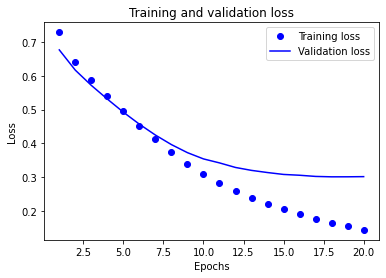

In [11]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

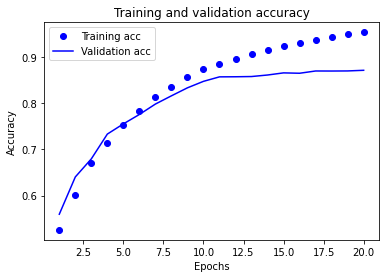

In [12]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()